In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 正解データ生成
def makeLabels(X, x1=0.35, y1=0.35, r1=0.3, x2=0.65, y2=0.65, r2=0.3):
    # 円1：中心 (0.35, 0.35), 半径 0.3 の円
    # 円2：中心 (0.65, 0.65), 半径 0.3 の円
    # 円1 と 円2 どちらかに（のみ）入っているならば 1、そうでなければ 0
    chk1 = np.less_equal(np.linalg.norm(X - np.array([x1, y1]), axis=1), r1)
    chk2 = np.less_equal(np.linalg.norm(X - np.array([x2, y2]), axis=1), r2)
    return np.where(np.logical_xor(chk1, chk2), 1, 0)

In [3]:
# サンプルデータ（訓練データ）生成
def makeData(N=1000):
    data = np.random.rand(N, 2)
    labels = makeLabels(data)
    return np.hstack([data, labels.reshape((N, 1))])

In [4]:
data = makeData(N=1000)

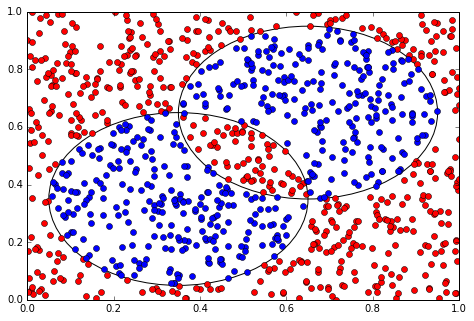

In [5]:
data0 = data[data[:,2]==0]
data1 = data[data[:,2]==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")

## RandomForest

In [6]:
X = data[:,0:2]; Y = data[:, 2]

In [7]:
# @np.vectorize
# def staircase01(x):
#     return 1.0 if x >= 0 else 0.0
# ↑意外と遅い
# def staircase01(x):
#     return np.round(sigmoid(x))
# ↓こっちの方が少し速い
def staircase01(x):
    return np.where(x < 0.0, 0.0, 1.0)

In [8]:
def calcGini(X, Y, fid, t):
    i0 = X[:, fid] <= t
    Y01 = [Y[i0], Y[~i0]]
    sz01 = [np.size(y) for y in Y01]
    sz = np.size(Y)
    gini = 0.0
    for i in [0, 1]:
        if sz01[i] == 0: continue
        y = Y01[i]
        sy0 = np.size(y[y == 0.0])
        g = 1.0
        for j in [sy0, sz01[i] - sy0]:
            ratio = j / sz01[i]
            g -= ratio**2
        gini += g * sz01[i] / sz
    return gini


In [9]:
def weakLearn(X, Y):
    N, M = np.shape(X)
    X1 = np.hstack((X, np.ones((N, 1))))
    fid = np.random.randint(M)
    xmin = np.min(X[:, fid])
    xmax = np.max(X[:, fid])
    xlin = np.linspace(xmin + 1e-5, xmax - 1e-5)
    if N < 50:
        xlin = X[:, fid] + 1e-5
    wbase = np.array([1 if i == fid else 0 for i in range(M)])
    gini = np.array([calcGini(X, Y, fid, t) for t in xlin])
    idx = np.argmin(gini)
    t = xlin[idx]
    w = np.concatenate((wbase, [-t]))
    h = lambda x: staircase01(np.dot(x, wbase) - t)
    return (h, w)

In [10]:
class AbstractNode(object):
    def __init__(self, level, data):
        self.level = level
        self.data = data
        self.is_leaf = False

class Node(AbstractNode):
    def __init__(self, level, data):
        super(Node, self).__init__(level, data)
        self.h = None
        self.left = None
        self.right = None

    def setH(self, h):
        self.h = h

    def setLeft(self, node):
        self.left = node
    
    def setRight(self, node):
        self.right = node

class Leaf(AbstractNode):
    def __init__(self, level, data):
        super(Leaf, self).__init__(level, data)
        y = data[:, np.size(data, 1)-1]
        self.value = 0.0 if np.sum(y) * 2 < np.size(y) else 1.0
        self.is_leaf = True


In [11]:
class DecisionTree(object):
    def __init__(self, data, weakLearn=weakLearn, maxLevel=30, minNodeSize=1):
        self.root = Node(0, data)
        self.weakLearn = weakLearn
        self.maxLevel = maxLevel
        self.minNodeSize = minNodeSize
        
    def train(self):
        from collections import deque
        N, M = np.shape(self.root.data)
        q = deque([(0, self.root)])
        while q:
            level, node = q.popleft()
            data = node.data
            X = data[:, 0:M-1]
            Y = data[:, M-1]
            (h, w) = self.weakLearn(X, Y)
            # print("(l,w)=(%d,%s)" % (level, str(w)))
            node.setH(h)
            Yd = h(X)
            data0 = data[Yd==0, :]
            data1 = data[Yd==1, :]
            if (
                    np.size(data0, 0) <= self.minNodeSize or 
                    level >= self.maxLevel or 
                    np.all(data0[:, M-1] == data0[0, M-1])):
                node.setLeft(Leaf(level + 1, data0))
            else:
                nnode = Node(level + 1, data0)
                node.setLeft(nnode)
                q.append((level + 1, nnode))
            if (
                    np.size(data1, 0) <= self.minNodeSize or 
                    level >= self.maxLevel or 
                    np.all(data1[:, M-1] == data1[0, M-1])):
                node.setRight(Leaf(level + 1, data1))
            else:
                nnode = Node(level + 1, data1)
                node.setRight(nnode)
                q.append((level + 1, nnode))
    
    def predict(self, X):
        N, M = np.shape(X)
        def getLeaf(node, x):
            while not node.is_leaf:
                r = node.h(x)
                node = node.left if r < 0.5 else node.right
            return node
        return np.apply_along_axis(lambda x: getLeaf(self.root, x).value, 1, X)

In [12]:
def randomForest(X, Y, weakLearn=weakLearn, T=100):
    N, M = np.shape(X)
    from collections import deque
    data = np.hstack((X, np.reshape(Y, (N, 1))))
    forest = deque([])
    for t in range(T):
        randidx = np.random.choice(range(N), N * 3 // 5, replace=False)
        S = data[randidx, :]
        tree = DecisionTree(S, weakLearn=weakLearn)
        tree.train()
        forest.append(tree)
    H = lambda x: np.where(np.sum(np.array([tree.predict(x) for tree in forest]), axis=0)>=T//2, 1.0, 0.0)
    return H

In [13]:
# %%prun
H = randomForest(X, Y)
# H = randomForest(X, Y, T=200)

In [14]:
# %%prun
Yd = H(X)

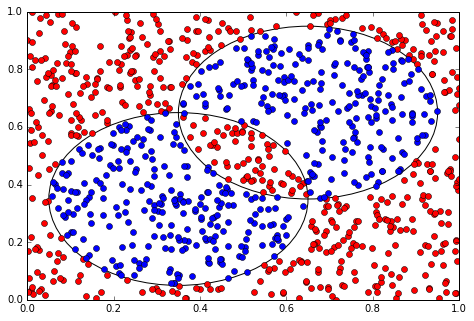

In [15]:
data0 = X[Yd==0]
data1 = X[Yd==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")

In [16]:
tp = np.sum(Y[Yd==1])
fp = np.sum(1-Y[Yd==1])
tn = np.sum(1-Y[Yd==0])
fn = np.sum(Y[Yd==0])
np.array([[tp,fp],[fn,tn]])

array([[ 478.,    0.],
       [   0.,  522.]])

In [17]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
print("accuracy: %.06f" % accuracy)

accuracy: 1.000000


In [18]:
precision = tp / (tp + fp)
print("precision: %.06f" % precision)

precision: 1.000000


In [19]:
recall = tp / (tp + fn)
print("recall: %.06f" % recall)

recall: 1.000000


In [20]:
f_measure = 2 * precision * recall / (precision + recall)
print("f_measure: %.06f" % f_measure)

f_measure: 1.000000


In [21]:
x_test = np.random.rand(100, 2)
y_test = H(x_test)

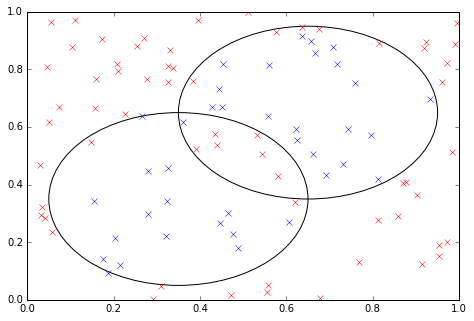

In [22]:
data0 = x_test[y_test==0]
data1 = x_test[y_test==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "rx")
plt.plot(data1[:,0], data1[:,1], "bx")